In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import time
import numpy as np
import cv2
from PIL import Image
import os
from matplotlib import pyplot as plt

#Turn all the randomisation off to ensure the results of every execution is the same 
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Denoising strategy

In [ ]:
##### Put denoising functions here

### Define Image Dataset structure and image transform

In [ ]:
IMG_SIZE = 224
FOLDER_PATH = "Images/100"

class ImageDataSet(Dataset):
    def __init__(self, image_names, transform):
        self.file_names = []
        self.labels = []
        for numeric_label, names in enumerate(image_names):
            self.labels.extend([numeric_label]*len(names))
            self.file_names.extend(names)

        self.transform = transform

    def __getitem__(self, index):
        img_name = self.file_names[index]
        img = Image.open(img_name).convert('RGB')
        img = self.transform(img)
        label = self.labels[index]
        return img, label
    
    def __len__(self):
        return len(self.file_names)


########################### We will have many transforms here. Store the transforms in list?
transform = transforms.Compose([
    #######################
    # Put your denoising function here
    # For example, `transforms.Lambda(lambda img: denoise_image_fn(img)),`   return data types: Image | torch.Tensor
    #########################
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Offically used by Pytorch
])
###############################


labels = ["B_Cells", "CD4+_T_Cells", "DCIS_1", "DCIS_2", "Invasive_Tumor", "Prolif_Invasive_Tumor"]
le = LabelEncoder()
numeric_labels = le.fit_transform(labels)
image_names = []
for _ in numeric_labels:
    image_names.append([])

for (dir_path, dir_names, file_names) in os.walk(FOLDER_PATH):
    parent_folder = os.path.basename(dir_path)
    if parent_folder in labels: # Read the subset of dataset to reduce training time 
        for file in file_names:
            image = cv2.imread(os.path.join(dir_path, file))
            if image.shape[0] < 100 and image.shape[1] < 100: #skip the small image, it doesn't give much info
                continue
            numeric_label = le.transform([parent_folder])[0]
            image_names[numeric_label].append(os.path.join(dir_path, file))

###### several datasets with different transform. Put datasets in a list
dataset = ImageDataSet(image_names, transform)
##############

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #check if the computer has GPU

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(image_names))
model = model.to(device)

c:\Users\brian\Desktop\DATA3888\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\brian\Desktop\DATA3888\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
num_epochs = 100
patience = 10 #for early stopping
batch_size = 32
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
##################### Use for loop to have different dataloader
_, subset = train_test_split(list(range(len(dataset))), test_size=0.5, random_state=0) #for faster training

train_idx, temp_idx = train_test_split(subset, test_size=0.3, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=0)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
###################


best_val_loss = float('inf')
epoch_no_improvement = 0
best_model_parameters = None


cnn_training_start = time.time()
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss/len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_parameters = model.state_dict()
        epoch_no_improvement = 0
    else:
        epoch_no_improvement += 1
        if epoch_no_improvement == patience:
            print(f"No improvement for {patience} epoches. Early stopping.")
            break
cnn_training_end = time.time()

if best_model_parameters is not None:
    model.load_state_dict(best_model_parameters)

Epoch [1/100], Loss: 0.5945
Validation Loss: 0.6322, Accuracy: 69.25%
Epoch [2/100], Loss: 0.5886
Validation Loss: 0.6537, Accuracy: 65.38%
Epoch [3/100], Loss: 0.5834
Validation Loss: 0.6215, Accuracy: 68.45%
Epoch [4/100], Loss: 0.5796
Validation Loss: 0.6113, Accuracy: 68.45%
Epoch [5/100], Loss: 0.5742
Validation Loss: 0.6055, Accuracy: 69.54%
Epoch [6/100], Loss: 0.5406
Validation Loss: 0.6562, Accuracy: 66.96%
Epoch [7/100], Loss: 0.5439
Validation Loss: 0.8038, Accuracy: 58.73%
Epoch [8/100], Loss: 0.5255
Validation Loss: 0.6414, Accuracy: 66.77%
Epoch [9/100], Loss: 0.4390
Validation Loss: 0.7482, Accuracy: 64.58%
Epoch [10/100], Loss: 0.3907
Validation Loss: 0.8909, Accuracy: 62.80%
Epoch [11/100], Loss: 0.3148
Validation Loss: 1.0213, Accuracy: 61.21%
Epoch [12/100], Loss: 0.2380
Validation Loss: 0.9329, Accuracy: 63.49%
Epoch [13/100], Loss: 0.2101
Validation Loss: 0.9221, Accuracy: 66.77%
Epoch [14/100], Loss: 0.1687
Validation Loss: 1.9443, Accuracy: 58.83%
Epoch [15/100],

In [9]:
torch.save(model.state_dict(), 'B_CD4_CNN.pth')

In [ ]:
############# for loop here as well
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# print(classification_report(y_true, y_pred, target_names=["Tumor", "Immune"]))
pretrained_cnn_accuracy = accuracy_score(y_true, y_pred)
print(pretrained_cnn_accuracy)
##############

0.628968253968254


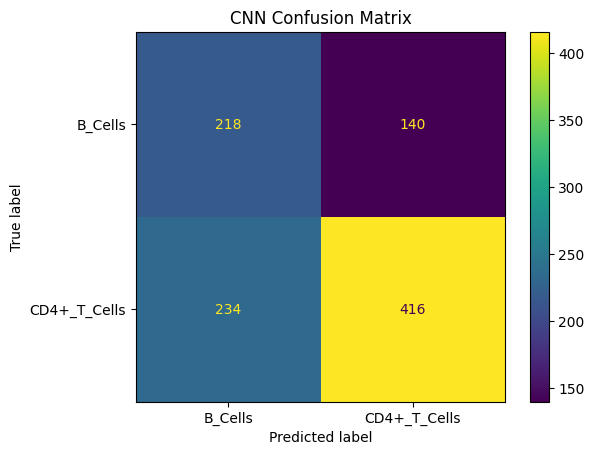

In [11]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)

cm_display.plot()
plt.title("CNN Confusion Matrix")
plt.show()